OA_600_Forskolin_10_01.czi
Shape of CZI data: (3, 956, 956)


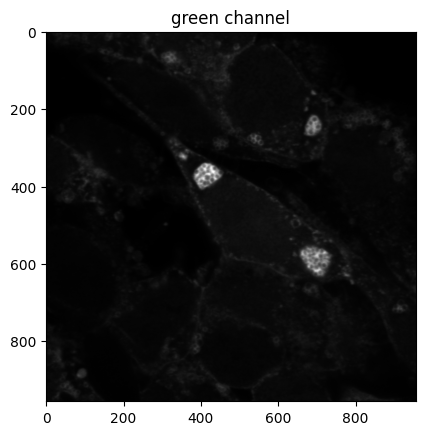

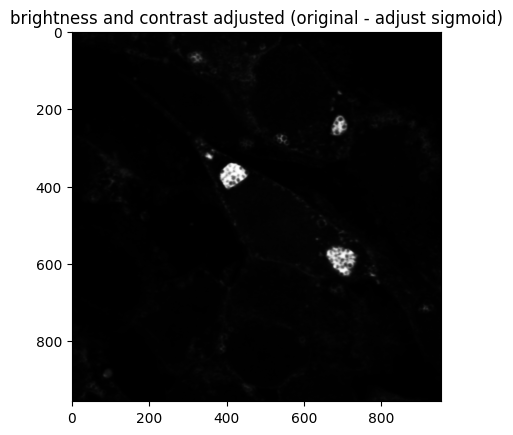

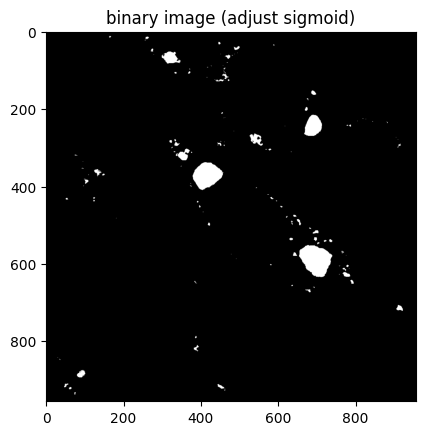

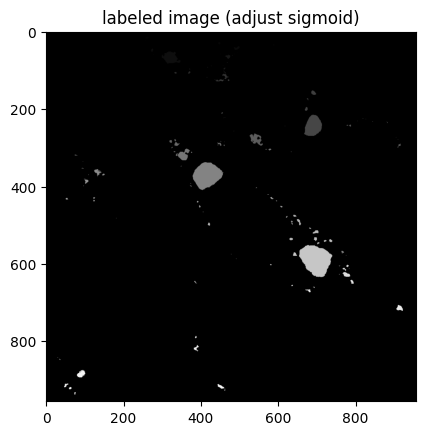

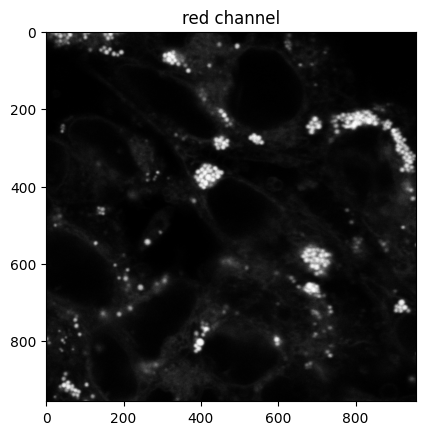

In [ ]:
# CHECK SEGMENTATION MANUALLY AND THEN EXCLUDE PROBLEMATIC IMAGES BY ANNOTATING ON EXCEL LIST IN ANALYSIS
# COUNTING OF NUCLEI SHOULD BE FINE BY CODE. MOST PROBLEMATIC IS GREEN, SECOND MOST PROBLEMATIC IS RED
import cv2

import numpy as np

from skimage import segmentation, measure

from scipy import ndimage

from skimage import exposure, filters, measure

import matplotlib.pyplot as plt

from skimage import morphology

from skimage.filters import gaussian

from skimage.filters import threshold_otsu

from skimage.morphology import binary_dilation, disk

import pandas as pd

from skimage.measure import label, regionprops

from skimage import img_as_ubyte

from skimage.morphology import remove_small_objects

from PIL import Image, ImageEnhance

from skimage.morphology import binary_dilation, disk

import skimage

 
import czifile


from os import listdir

from os.path import isfile, join

# global ave_child_inclusion_size_all

def calculate_circularity(area, perimeter):
    circularity = (4 * np.pi * area) / (perimeter**2)
    return circularity


def sigmoid_contrast_adjustment(image, gain=100, bias=0.1): 

    adjusted_image = 1 / (1 + np.exp(-gain * (image - bias))) 

    return adjusted_image 


def quantify_lipid_inside_inclusions(image_path, inclusion_mask_path, lipid_mask_path):

    # Read the image, inclusion mask, and lipid mask

    image = cv2.imread(image_path)

    inclusion_mask = cv2.imread(inclusion_mask_path, cv2.IMREAD_GRAYSCALE)

    lipid_mask = cv2.imread(lipid_mask_path, cv2.IMREAD_GRAYSCALE)

 

    # Threshold the lipid mask to segment lipid droplets

    _, lipid_binary = cv2.threshold(lipid_mask, 1, 255, cv2.THRESH_BINARY)

 

    # Find contours of lipid droplets and inclusions

    lipid_contours, _ = cv2.findContours(lipid_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    inclusion_contours, _ = cv2.findContours(inclusion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

 

    # Initialize counter for lipid droplets inside inclusions

    num_lipid_inside_inclusions = 0

 

    # Loop through each lipid droplet and check if it's inside any inclusion

    for lipid_contour in lipid_contours:

        for inclusion_contour in inclusion_contours:

            # Check if the bounding rectangles of lipid and inclusion overlap

            if (cv2.boundingRect(lipid_contour)[0] >= cv2.boundingRect(inclusion_contour)[0] and \

               cv2.boundingRect(lipid_contour)[0] + cv2.boundingRect(lipid_contour)[2] <= cv2.boundingRect(inclusion_contour)[0] + cv2.boundingRect(inclusion_contour)[2] and \

               cv2.boundingRect(lipid_contour)[1] >= cv2.boundingRect(inclusion_contour)[1] and \

               cv2.boundingRect(lipid_contour)[1] + cv2.boundingRect(lipid_contour)[3] <= cv2.boundingRect(inclusion_contour)[1] + cv2.boundingRect(inclusion_contour)[3]):

                num_lipid_inside_inclusions += 1

                break  # Break the inner loop if the lipid is inside any inclusion

 

    # Calculate the percentage of lipid droplets inside inclusions

    total_lipid_droplets = len(lipid_contours)

    percentage_inside_inclusions = (num_lipid_inside_inclusions / total_lipid_droplets) * 100

 

    return percentage_inside_inclusions

def flatten(xss):
    return [x for xs in xss for x in xs]

def quantify_inclusion_structure(inclusion_mask):

    cv_image = cv2.imread(inclusion_mask, cv2.IMREAD_GRAYSCALE)

    cv_image = cv2.resize(cv_image, (956, 956))

    print("cv image shape", cv_image.shape)

    # print(cv_image.shape)

    # Threshold the inclusion mask

    _, binary_mask = cv2.threshold(cv_image, 1, 255, cv2.THRESH_BINARY)

    # cv_image = img_as_ubyte(inclusion_mask)

    # inclusion_mask_gr = cv_image[:, :, 0]

    # Read the inclusion mask

    # inclusion_mask_gr = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

 

    # Find contours of inclusions

    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    contours_tree, hierarchy_tree = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    blank_image = np.zeros((binary_mask.shape[0],binary_mask.shape[0],3), np.uint8)

    # image = cv2.drawContours(blank_image, contours, -1, (0, 0, 255), 2) 
  
    # plt.imshow(image) 

    # plt.title("contours")

    # plt.show()

 

    # Initialize counters

    num_solid_inclusions = 0

    num_hollow_inclusions = 0

    count = 0

    all_child_contour_areas = []

    save_child_indices = []

 

    # Loop through each inclusion and check its structure

    # holes = [contours[i] for i in range(len(contours)) if hierarchy[0][i][3] != -1]

    # print(holes)

    # num_solid_inclusions = [contours[i] for i in range(len(contours)) if hierarchy[0][i][3] == -1]

    # total_inclusions = 0

    # print("number of holes:", len(holes))

    for i in range(0,len(contours_tree)):

        # total_inclusions = total_inclusions + 1

        # print(hierarchy[0][count][3])

        # print(hierarchy)
        
        # # if the contour has a child but no parent, it is holed
        # if(hierarchy[0][count][2] != -1 and hierarchy[0][count][3] == -1):
        #     num_holed_inclusions = num_holed_inclusions + 1
        # # if the contour does not have a child or a parent, it is solid
        # if(hierarchy[0][count][2] == -1 and hierarchy[0][count][3] == -1):
        #     num_solid_inclusions = num_solid_inclusions + 1

        # if the contour has a child and it is of a certain size, it is hollow
        # hierarchy[0][i][2] should give the index+1 of the child contour
        if(hierarchy_tree[0][i][2] != -1):
            if(cv2.contourArea(contours_tree[i]) >=10):
                child_contour_area = cv2.contourArea(contours_tree[hierarchy_tree[0][i][2]])
                if(child_contour_area >= 5):
                    save_child_indices.append(hierarchy_tree[0][i][2])
                    all_child_contour_areas.append(child_contour_area)
                # print("all child contour areas", all_child_contour_areas)
                # if(child_contour_area==14.5):
                #     image = cv2.drawContours(blank_image, contours, hierarchy[0][i][2], (0, 0, 255), 1) 
                #     plt.imshow(image) 
    
                #     plt.title("smallest child contour hollow")
                
                #     plt.show()
                # if(child_contour_area >= 10):
                #     num_hollow_inclusions = num_hollow_inclusions + 1
            # if the contour does not have a child, it is solid
        if(hierarchy_tree[0][i][2] == -1):
            if(cv2.contourArea(contours_tree[i]) >=10):
                num_solid_inclusions = num_solid_inclusions + 1

    for i in range(0,len(all_child_contour_areas)):


        if(all_child_contour_areas[i]==152.5):
            image = cv2.drawContours(blank_image, contours, save_child_indices[i], (0, 0, 255), 2) 
            plt.imshow(image) 

            plt.title("largest child contour swiss cheese")
        
            plt.show()
        if(all_child_contour_areas[i] >= 10):
            num_hollow_inclusions = num_hollow_inclusions + 1
        
           
            
            
        

 

    # Calculate the percentage of solid and holed inclusions

    total_inclusions = num_hollow_inclusions + num_solid_inclusions

    # print("total inclusions:", total_inclusions)

    ave_child_inclusion_size = np.mean(all_child_contour_areas)

    # print("average child contour area for swiss cheese inclusions:", ave_child_inclusion_size)

    # print(contours)

    percentage_solid = (num_solid_inclusions / total_inclusions) * 100

    percentage_hollow = (num_hollow_inclusions / total_inclusions) * 100

    # print("number of inclusions", total_inclusions)

    # print("number of inclusions", total_inclusions)


    return all_child_contour_areas, total_inclusions, num_hollow_inclusions, percentage_solid, percentage_hollow


images_to_analyze = [f for f in listdir("013124 (012524_3)_Forskolin_Dose_Response") if isfile(join("013124 (012524_3)_Forskolin_Dose_Response", f))]

number_of_nuclei_list = []

number_of_inclusions_list = []

percent_SA_lipids_list = []

percent_SA_lipids_list_inclusions = []

percent_hollow_inclusions_list = []

percent_solid_inclusions_list = []

percent_swiss_cheese_inclusions_list = []

num_hollow_inclusions_list = []

ave_child_inclusion_size_all = []

num_swiss_cheese_list = []

num_solid_list = []

SA_lipids_list = []

SA_inclusions_list = []

import math



for path in images_to_analyze:

    print(path)


    # Read the CZI file
    

    czi_path = '013124 (012524_3)_Forskolin_Dose_Response/' + path
    
   

    czi_file = czifile.CziFile(czi_path)

   

    czi_data = czi_file.asarray()

 

    shape = czi_data.shape

    image_squeezed = np.squeeze(czi_data)

    shape = image_squeezed.shape

 

    print(f"Shape of CZI data: {shape}")

    green_channel = image_squeezed[1,:,:]

    plt.imshow(green_channel, cmap='gray')

    plt.title("green channel")
    
    plt.show()

    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.4)

    plt.imshow(confocal_img, cmap='gray')

    plt.title("brightness and contrast adjusted (original - adjust sigmoid)")
    
    plt.show()
    # ---- segmentation
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())

    # min = confocal_img.getextrema()
    
    # threshold the image
    
    threshold_value = 0.06 # adjust this value as needed
    
    binary_image_inclusions = confocal_img > threshold_value

    # plt.title("thresholded image")

    # plt.axis('off')

    # plt.imshow(binary_image_inclusions, cmap='gray')

    # plt.savefig(path + "_new.png", transparent=True, dpi = "figure", bbox_inches='tight', pad_inches=0)


    plt.imshow(binary_image_inclusions, cmap='gray')

    plt.title("binary image (adjust sigmoid)")

    plt.show()

    
    
    # plt.show()
    
    # Label the objects: Use connected component analysis to label the segmented inclusions. 
    
    labeled_image_inclusions = label(binary_image_inclusions)

    plt.imshow(labeled_image_inclusions, cmap='gray')

    plt.title("labeled image (adjust sigmoid)")
    
    plt.show()

    props_count_inclusions = regionprops(labeled_image_inclusions, confocal_img)

    count_inclusions = len(props_count_inclusions)

    sizes_inclusions = []

    for prop in props_count_inclusions:
        
        sizes_inclusions.append(prop.area)

    # print("total inclusions count:", count_inclusions)

    # inclusion_mask = path + "_new.png"

    
    
    # # plt.imshow(labeled_image_inclusions, cmap='gray')
    
    # # plt.savefig(path + ".png")


    # # inclusion_mask_path = path + ".png"

    # # print(inclusion_mask_path)

    # # lipid_mask_path = 'path/to/your/lipid_mask.png'

 

    # # percentage_inside_inclusions = quantify_lipid_inside_inclusions(czi_path, inclusion_mask_path, lipid_mask_path)

    # # print(f"Percentage of lipid droplets inside inclusions: {percentage_inside_inclusions}%")



 

    # # Example usage

    # all_child_contour_areas, total_inclusions, num_hollow_inclusions, percentage_solid, percentage_hollow = quantify_inclusion_structure(inclusion_mask)

    # ave_child_inclusion_size_all.append(all_child_contour_areas)

    # number_of_inclusions_list.append(total_inclusions)

    # print(f"Percentage of solid inclusions: {round(percentage_solid,2)}%")

    # print(f"Percentage of hollow inclusions: {round(percentage_hollow,2)}%")

    # percent_hollow_inclusions_list.append(round(percentage_hollow,2))

    # --------------- RED CHANNEL -----------------------------

    red_channel = image_squeezed[0,:,:]

    plt.imshow(red_channel, cmap='gray')

    plt.title("red channel")
    
    plt.show()

    confocal_img = exposure.adjust_sigmoid(red_channel, cutoff=0.4)

    plt.imshow(confocal_img, cmap='gray')

    plt.title("brightness and contrast adjusted (original - adjust sigmoid)")
    
    plt.show()
    # ---- segmentation
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())

    # min = confocal_img.getextrema()
    
    # threshold the image
    
    threshold_value = 0.06 # adjust this value as needed
    
    binary_image_lipids = confocal_img > threshold_value

    # plt.title("thresholded image")

    plt.axis('off')

    # plt.imshow(binary_image_lipids, cmap='gray')

    # plt.savefig(path + ".png", transparent=True, dpi = "figure", bbox_inches='tight', pad_inches=0)


    plt.imshow(binary_image_lipids, cmap='gray')

    plt.title("binary image (adjust sigmoid)")

    plt.show()

    
    
    # plt.show()
    
    # Label the objects: Use connected component analysis to label the segmented inclusions. 
    
    labeled_image_lipids = label(binary_image_lipids)

    plt.imshow(labeled_image_lipids, cmap='gray')

    plt.title("labeled image (adjust sigmoid)")
    
    

    props_lipids = regionprops(labeled_image_lipids, confocal_img)

    sizes_lipids = []

    save_props_hollow = []

    for prop in props_lipids:

        sizes_lipids.append(prop.area)

    # for prop in props_lipids:
    #     if(prop.perimeter > 0 and prop.area >= 20):
    #         circularity_index = calculate_circularity(prop.area, prop.perimeter)
    #         print(f"Object {prop.label} - Circularity Index: {circularity_index}")
    #         print(f"Object {prop.label} - Surface Area: {prop.area}")
    #         if(circularity_index >= 0.5 and prop.area >= 800):
    #             save_props_hollow.append(prop)
    #         y = prop.centroid[1]
    #         x = prop.centroid[0] 
    #         plt.text(y, x, str(prop.label), color = "red")
    #         sizes_lipids.append(prop.area)
            
    plt.show()

    from skimage import measure, util
        
        

    # Get the region properties table as a dictionary
    table = measure.regionprops_table(labeled_image_lipids, confocal_img, properties=('label', 'area', 'perimeter', 'major_axis_length', 'minor_axis_length'))
    
    # Calculate the circularity index for each region
    circularity_index = 4 * np.pi * table['area'] / ((table['perimeter'])**2)

    # print("circularity index", circularity_index[31])

    # print("area", table['area'][31])

    # print("circularity index", circularity_index)
    
    # Define the size and circularity index thresholds
    min_size = 700
    # max_size = 1000
    min_circularity = 0.65
    # max_circularity = 0.9
    
    # Filter the labels that satisfy the thresholds
    input_labels = table['label']
    output_labels = input_labels * (table['area'] >= min_size) * (circularity_index >= min_circularity)
    
    # Remap the label image using the filtered labels
    mask = util.map_array(labeled_image_lipids, input_labels, output_labels)

    # Define the size and circularity index thresholds
    min_size = 20
    max_circularity = 0.65
    
    # Filter the labels that satisfy the thresholds
    input_labels = table['label']
    output_labels = input_labels * (table['area'] >= min_size) * (circularity_index < max_circularity)
    
    # Remap the label image using the filtered labels
    mask_swiss_cheese = util.map_array(labeled_image_lipids, input_labels, output_labels)

    # print("mask swiss cheese", mask_swiss_cheese)

    # print("binary image inclusions", binary_image_inclusions)
    

    plt.imshow(mask_swiss_cheese, cmap='gray')

    plt.title("mask swiss cheese")

    plt.show()

    plt.imshow(binary_image_inclusions, cmap='gray')

    plt.title("binary_image_inclusions")

    plt.show()

    intersection_mask_swiss_cheese = mask_swiss_cheese.astype(bool) & binary_image_inclusions

    plt.imshow(mask, cmap='gray')

    plt.title("filter for hollow inclusions")

    plt.show()

    plt.imshow(intersection_mask_swiss_cheese, cmap='gray')

    plt.title("filter for swiss cheese inclusions")

    plt.show()

    radius = 9 # Adjust this value based on your requirement
            
    selem = disk(radius)

    binary_image_lipids_dilate = binary_dilation(intersection_mask_swiss_cheese, selem)

    plt.imshow(binary_image_lipids_dilate, cmap='gray')

    plt.title("filter for swiss cheese inclusions dilated")

    plt.show()

    labeled_lipids_swiss_cheese = label(intersection_mask_swiss_cheese)

    props_swiss_cheese = regionprops(labeled_lipids_swiss_cheese)

    radius = 1.1 # Adjust this value based on your requirement
            
    selem = disk(radius)

    binary_image_lipids_dilate = binary_dilation(mask, selem)

    plt.imshow(binary_image_lipids_dilate, cmap='gray')

    plt.title("dilation of lipids for hollow inclusions")

    plt.show()

    intersection_mask = binary_image_lipids_dilate & binary_image_inclusions

    plt.imshow(intersection_mask, cmap='gray')

    plt.title("overlay of dilated lipids with inclusions")

    plt.show()

    labeled_lipids_hollow = label(intersection_mask)

    props = regionprops(labeled_lipids_hollow)

    total_hollow_inclusions = len(props)

    print("total hollow inclusions:", total_hollow_inclusions)

    print("total swiss cheese inclusions:", len(props_swiss_cheese))

    num_swiss_cheese_list.append(len(props_swiss_cheese))

    inclusions_solid_mask = binary_image_inclusions & ~binary_image_lipids_dilate & ~mask_swiss_cheese

    labeled_inclusions_solid = label(inclusions_solid_mask)

    props = regionprops(labeled_inclusions_solid)

    total_solid_inclusions = 0

    for prop in props:
        if(prop.area >= 10):
            total_solid_inclusions = total_solid_inclusions + 1

    print("total solid inclusions", total_solid_inclusions)

    num_solid_list.append(total_solid_inclusions)

    total_inclusions = total_hollow_inclusions + total_solid_inclusions + len(props_swiss_cheese)

    number_of_inclusions_list.append(total_inclusions)
    

    # --------------- BLUE CHANNEL -----------------------------

    blue_channel = image_squeezed[2,:,:]

    plt.imshow(blue_channel, cmap='gray')

    plt.title("blue channel")
    
    plt.show()

    blurred_dapi = gaussian(blue_channel, sigma=2)
     
    # Threshold the image: Use an appropriate thresholding method to segment the nuclei from the background. 
    
    threshold_value = threshold_otsu(blurred_dapi)
    
    binary_image = blurred_dapi > threshold_value
    
    # Clean up the segmentation: Use morphology operations to remove small objects and fill in any holes in the nuclei. 
    
    filled_image = morphology.remove_small_holes(binary_image, area_threshold=50000)
    
    # Remove objects with less than 100 pixels
    
    min_size = 400
    
    cleaned_image = remove_small_objects(filled_image, min_size=min_size) 
    
    # assume 'binary_image' is the binary image containing the segmented nuclei
    
    # set the size of the dilation element
    
    selem = disk(5)
    
    # dilate the binary image to merge adjacent objects

    print(cleaned_image.shape)
    
    merged_image = binary_dilation(cleaned_image, footprint=selem)
    
    # Label the objects: Use connected component analysis to label the segmented nuclei. 
    
    labeled_image_nuclei = label(merged_image)
    
    # Count the number of objects: Count the number of unique labels in the labeled image. 
    
    n_objects = len(np.unique(labeled_image_nuclei)) - 1  # exclude background label 0
    
    print(f"Number of nuclei: {n_objects}")

    number_of_nuclei_list.append(n_objects)
    
    # show segmented image 
    
    plt.imshow(labeled_image_nuclei, cmap='gray')

    plt.title("segmented image nuclei")
    
    plt.show()

    intersection_mask_lipids_inclusions = np.logical_and(binary_image_inclusions, binary_image_lipids)

    props = regionprops(intersection_mask_lipids_inclusions.astype(np.uint8))

    prop_sizes = []

    for prop in props:
        
        prop_sizes.append(prop.area)

    total_area_intersection = np.sum(prop_sizes)

    total_area_lipids = np.sum(sizes_lipids)

    total_area_inclusions = np.sum(sizes_inclusions)

    percent_SA_lipids = (total_area_intersection/total_area_lipids)*100

    SA_lipids_list.append(total_area_lipids)

    percent_SA_lipids_inclusions = (total_area_intersection/total_area_inclusions)*100

    SA_inclusions_list.append(total_area_inclusions)

    print("percent intersection overlapping with SA of lipids:",round(percent_SA_lipids,2))

    print("percent intersection overlapping with SA of inclusions:",round(percent_SA_lipids_inclusions,2))

    percent_SA_lipids_list.append(round(percent_SA_lipids,2))

    percent_SA_lipids_list_inclusions.append(round(percent_SA_lipids_inclusions,2))

    num_hollow_inclusions_list.append(total_hollow_inclusions)

    percentage_hollow = total_hollow_inclusions/(total_hollow_inclusions + total_solid_inclusions + len(props_swiss_cheese))*100

    percent_hollow_inclusions_list.append(round(percentage_hollow,2))

    percentage_solid = total_solid_inclusions/(total_hollow_inclusions + total_solid_inclusions + len(props_swiss_cheese))*100

    percent_solid_inclusions_list.append(round(percentage_solid,2))

    percentage_swiss_cheese = len(props_swiss_cheese)/(total_hollow_inclusions + total_solid_inclusions + len(props_swiss_cheese))*100

    percent_swiss_cheese_inclusions_list.append(round(percentage_swiss_cheese,2))

    

# print("min child contour size for swiss cheese inclusions", np.min(np.array(flatten(ave_child_inclusion_size_all))))
# print("max child contour size for swiss cheese inclusions", np.max(np.array(flatten(ave_child_inclusion_size_all))))
# print("mean child contour size for swiss cheese inclusions", np.mean(np.array(flatten(ave_child_inclusion_size_all))))
# print("median child contour size for swiss cheese inclusions", np.median(np.array(flatten(ave_child_inclusion_size_all))))
# print("all child contour sizes", ave_child_inclusion_size_all)
df = pd.DataFrame(np.array(images_to_analyze).flatten())
df.rename(columns={0: 'image'}, inplace=True)
df.insert(1, "number_of_nuclei", np.array(number_of_nuclei_list).flatten(), True)
df.insert(2, "number_of_inclusions", np.array(number_of_inclusions_list).flatten(), True)
df.insert(3, "percent_SA_lipids_overlap_lip", np.array(percent_SA_lipids_list).flatten(), True)
df.insert(4, "percent_SA_lipids_overlap_inc", np.array(percent_SA_lipids_list_inclusions).flatten(), True)
df.insert(5, "SA_lipids", np.array(SA_lipids_list).flatten(), True)
df.insert(6, "SA_inclusions", np.array(SA_inclusions_list).flatten(), True)
df.insert(7, "num_swiss_cheese_inclusions", np.array(num_swiss_cheese_list).flatten(), True)
df.insert(8, "num_hollow_inclusions", np.array(num_hollow_inclusions_list).flatten(), True)
df.insert(9, "num_solid_inclusions", np.array(num_solid_list).flatten(), True)
df.insert(10, "percent_hollow_inclusions", np.array(percent_hollow_inclusions_list).flatten(), True)
df.insert(11, "percent_swiss_cheese_inclusions", np.array(percent_swiss_cheese_inclusions_list).flatten(), True)
df.insert(12, "percent_solid_inclusions", np.array(percent_solid_inclusions_list).flatten(), True)
df.to_excel("lipids_analysis.xlsx")